<a href="https://colab.research.google.com/github/seunghyeokkim/bopibopi/blob/main/%ED%86%B5%ED%95%A9%EB%B3%B81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers[torch] accelerate==0.20.1 pandas scikit-learn tqdm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.5/227.5 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 53.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.2 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of transformers[torch] to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 80.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 106.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 103.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 90.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install soynlp emoji


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 416.8/416.8 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 8.0 MB/s eta 0:00:00


In [ ]:
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# 데이터를 로드하는 코드
data = pd.read_csv('/content/cleaned_translated_sms_data (1).csv')  # 다운로드한 파일 경로로 변경하세요.
# 데이터셋 내의 모든 메시지를 문자열로 변환합니다.
data['message'] = data['message'].astype(str)

# 라벨을 숫자 형태로 변환
label_mapping = {'ham': 0, 'spam': 1}
data['label'] = data['label'].map(label_mapping)

# 데이터셋 클래스 정의
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': label}

# 토크나이저 및 모델 로드
tokenizer = AutoTokenizer.from_pretrained("beomi/kcbert-base")
model = AutoModelForSequenceClassification.from_pretrained("beomi/kcbert-base", num_labels=2)

# 데이터셋 생성 및 분할
max_length = 128
dataset = CustomDataset(data['message'].tolist(), data['label'].tolist(), tokenizer, max_length)
train_dataset, valid_dataset = train_test_split(dataset, test_size=0.15, random_state=42)

# 데이터 로더 생성
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# 모델 훈련
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 옵티마이저 및 손실 함수 설정
optimizer = AdamW(model.parameters(), lr=1e-5)
criterion = torch.nn.CrossEntropyLoss()

# 훈련 시작
epochs = 3
for epoch in range(epochs):
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}", leave=False)
    for batch in progress_bar:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}/{epochs} - 평균 손실: {avg_loss:.4f}")

# 모델 저장
model.save_pretrained("/content/saved_model")

# 모델 평가
model.eval()
total_eval_accuracy = 0
for batch in tqdm(valid_dataloader, desc="검증중", leave=False):
    batch = {k: v.to(device) for k, v in batch.items()}

    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    correct = (predictions == batch['labels']).float().sum()
    total_eval_accuracy += correct / len(predictions)

avg_val_accuracy = total_eval_accuracy / len(valid_dataloader)
print(f"검증 정확도: {avg_val_accuracy:.4f}")

# 예측 정확도 계산 함수 (필요한 경우


(…)-base/resolve/main/tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

(…)omi/kcbert-base/resolve/main/config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

(…)beomi/kcbert-base/resolve/main/vocab.txt:   0%|          | 0.00/250k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of the model checkpoint at beomi/kcbert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initiali

Epoch 1:   0%|          | 0/297 [00:00<?, ?it/s]

Epoch 1/3 - 평균 손실: 0.1042


Epoch 2:   0%|          | 0/297 [00:00<?, ?it/s]

Epoch 2/3 - 평균 손실: 0.0308


Epoch 3:   0%|          | 0/297 [00:00<?, ?it/s]

Epoch 3/3 - 평균 손실: 0.0110


검증중:   0%|          | 0/53 [00:00<?, ?it/s]

검증 정확도: 0.9892


In [ ]:
# 모델 평가
model.eval()  # 모델을 평가 모드로 설정
total_eval_accuracy = 0
total_eval_loss = 0
eval_steps = 0

# 검증 데이터 로더를 통해 배치를 반복 처리
for batch in tqdm(valid_dataloader, desc="검증중", leave=False):
    batch = {k: v.to(device) for k, v in batch.items()}  # 배치 내의 모든 텐서를 GPU로 이동

    with torch.no_grad():  # 그래디언트 계산을 중지하여 메모리 사용량을 줄이고 계산 속도를 빠르게 함
        outputs = model(**batch)

    logits = outputs.logits
    loss = criterion(logits, batch['labels'])
    total_eval_loss += loss.item()

    predictions = torch.argmax(logits, dim=-1)
    correct = (predictions == batch['labels']).float().sum()
    total_eval_accuracy += correct

# 전체 검증 정확도와 평균 손실을 계산
avg_val_accuracy = total_eval_accuracy / len(valid_dataset)
avg_val_loss = total_eval_loss / len(valid_dataloader)

print(f"검증 정확도: {avg_val_accuracy:.4f}")
print(f"검증 손실: {avg_val_loss:.4f}")


검증중:   0%|          | 0/53 [00:00<?, ?it/s]

검증 정확도: 0.9916
검증 손실: 0.0629


검증 중:   0%|          | 0/53 [00:00<?, ?it/s]

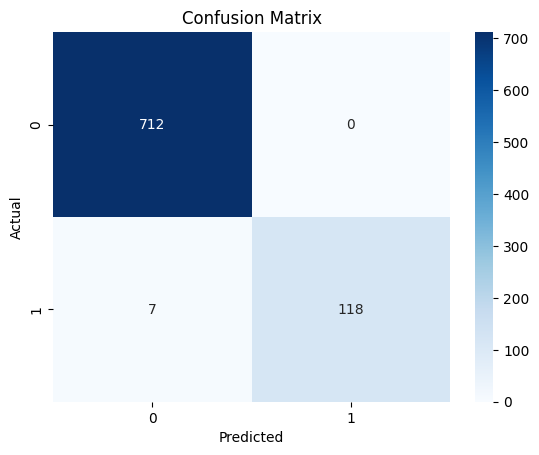

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       712
           1       1.00      0.94      0.97       125

    accuracy                           0.99       837
   macro avg       1.00      0.97      0.98       837
weighted avg       0.99      0.99      0.99       837



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# 실제 레이블과 예측 레이블을 저장하기 위한 리스트
true_labels = []
pred_labels = []

# 모델을 평가 모드로 설정합니다.
model.eval()

# tqdm 진행 바를 설정합니다.
progress_bar = tqdm(valid_dataloader, desc='검증 중')

# 검증 데이터 로더를 순회하면서 예측을 수행합니다.
with torch.no_grad():
    for batch in progress_bar:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits

        # 예측 레이블을 추출합니다.
        preds = torch.argmax(logits, dim=1)

        # 실제 레이블과 예측 레이블을 리스트에 추가합니다.
        true_labels.extend(batch['labels'].cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

# 혼동 행렬을 계산합니다.
conf_mat = confusion_matrix(true_labels, pred_labels)

# 혼동 행렬을 히트맵으로 표시합니다.
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# 분류 보고서를 출력합니다.
print(classification_report(true_labels, pred_labels))


In [ ]:
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# 데이터를 로드하는 코드
data = pd.read_csv('/content/combined_binary_labels_data.csv')  # 적절한 파일 경로로 변경하세요.
# 데이터셋 내의 모든 메시지를 문자열로 변환합니다.
data['message'] = data['message'].astype(str)

# 데이터셋 클래스 정의
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': label}

# 토크나이저 및 모델 로드
tokenizer = AutoTokenizer.from_pretrained("beomi/kcbert-base")
model = AutoModelForSequenceClassification.from_pretrained("beomi/kcbert-base", num_labels=2)

# 데이터셋 생성 및 분할
max_length = 128
dataset = CustomDataset(data['message'].tolist(), data['label'].tolist(), tokenizer, max_length)
train_dataset, valid_dataset = train_test_split(dataset, test_size=0.15, random_state=42)

# 데이터 로더 생성
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# 모델 훈련을 위한 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 옵티마이저 및 손실 함수 설정
optimizer = AdamW(model.parameters(), lr=1e-5)
criterion = torch.nn.CrossEntropyLoss()

# 훈련 시작
epochs = 3
for epoch in range(epochs):
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}", leave=False)
    for batch in progress_bar:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}/{epochs} - 평균 손실: {avg_loss:.4f}")

# 모델 저장
model.save_pretrained("/content/saved_model")

# 모델 평가
model.eval()
total_eval_accuracy = 0
for batch in tqdm(valid_dataloader, desc="검증중", leave=False):
    batch = {k: v.to(device) for k, v in batch.items()}

    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    correct = (predictions == batch['labels']).float().sum()
    total_eval_accuracy += correct / len(predictions)

avg_val_accuracy = total_eval_accuracy / len(valid_dataloader)
print(f"검증 정확도: {avg_val_accuracy:.4f}")


Some weights of the model checkpoint at beomi/kcbert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initiali

Epoch 1:   0%|          | 0/395 [00:00<?, ?it/s]

Epoch 1/3 - 평균 손실: 0.0902


Epoch 2:   0%|          | 0/395 [00:00<?, ?it/s]

Epoch 2/3 - 평균 손실: 0.0254


Epoch 3:   0%|          | 0/395 [00:00<?, ?it/s]

Epoch 3/3 - 평균 손실: 0.0116


검증중:   0%|          | 0/70 [00:00<?, ?it/s]

검증 정확도: 0.9955


검증 중:   0%|          | 0/70 [00:00<?, ?it/s]

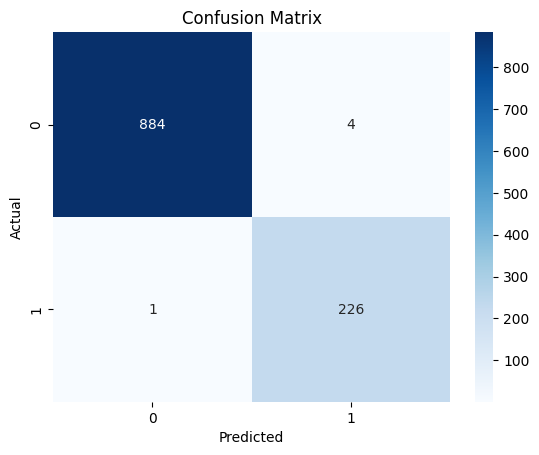

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       888
           1       0.98      1.00      0.99       227

    accuracy                           1.00      1115
   macro avg       0.99      1.00      0.99      1115
weighted avg       1.00      1.00      1.00      1115



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# 실제 레이블과 예측 레이블을 저장하기 위한 리스트
true_labels = []
pred_labels = []

# 모델을 평가 모드로 설정합니다.
model.eval()

# tqdm 진행 바를 설정합니다.
progress_bar = tqdm(valid_dataloader, desc='검증 중')

# 검증 데이터 로더를 순회하면서 예측을 수행합니다.
with torch.no_grad():
    for batch in progress_bar:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits

        # 예측 레이블을 추출합니다.
        preds = torch.argmax(logits, dim=1)

        # 실제 레이블과 예측 레이블을 리스트에 추가합니다.
        true_labels.extend(batch['labels'].cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

# 혼동 행렬을 계산합니다.
conf_mat = confusion_matrix(true_labels, pred_labels)

# 혼동 행렬을 히트맵으로 표시합니다.
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# 분류 보고서를 출력합니다.
print(classification_report(true_labels, pred_labels))
